# rACS in Real-Multiplexer

In [1]:
# Logger
import logging
logging.basicConfig(level=logging.INFO)

from itertools import groupby

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import local paths
import sys, os
sys.path.append(os.path.abspath('../../..'))
sys.path.append(os.path.abspath('../../../../openai-envs'))

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS module
from lcs.agents.racs import RACS, Configuration

# Load OpenAI environments
import gym
import gym_multiplexer

## Real-Multiplexer
In 3-bit multiplexer first bit is responsible for addressing the correct answer.

> For testing purposes the last bit is used as a flag indicating if the action chosen by the algorithm was correct. The environment always introduces it with 0. It's value is changed to 1 if the action was chosen correctly.

In [2]:
# Environment initialization
rmpx = gym.make('real-multiplexer-3bit-v0')

rMPX acts like a normal MPX with the difference that instead on boolean values floating numbers within range `[0,1]` are used. Environment used internal threshold to transform them into boolean values (`threshold=0.5` is used as default).

In [3]:
state = rmpx.reset()
state

[0.6787622956334223, 0.9544450977481421, 0.2340574547788823, 0.0]

Which corresponds to the following binary MPX:

In [4]:
threshold = 0.5  # secret knowledge
binary_state = map(lambda x: 1 if x > threshold else 0, state)

list(binary_state)

[1, 1, 0, 0]

Depending on the MPX size we have some actions to be executed. In 3-bit variant first bit (_address bit_) points to the correct answer (two possible values).

In [5]:
rmpx.action_space.n

2

We can also investigate the properties of a single observation (like vector dimension, lower and upper bound of each attribute).

In [6]:
print(f"Observation shape: {rmpx.observation_space.shape}")
print(f"Upper bounds: {rmpx.observation_space.low}")
print(f"Lower bounds: {rmpx.observation_space.high}")

Observation shape: (4,)
Upper bounds: [0. 0. 0. 0.]
Lower bounds: [1. 1. 1. 1.]


## Experiment
In the experiment each attribute range will be represented as an _unorded bounded tuple_ with desired encoding resolution.

In [7]:
# Define function for fetching interesing metrics
def rmpx_metrics(population, environment):
    return {
        'population': len(population),
        'numerosity': sum(cl.num for cl in population),
        'reliable': len([cl for cl in population if cl.is_reliable()]),
    }

Define a function for executing experiments

In [8]:
def perform_experiment(env, trials):
    # create configuration
    cfg = Configuration(env.observation_space.shape[0], env.action_space.n,
                    metrics_trial_frequency=5,
                    user_metrics_collector_fcn=rmpx_metrics,
                    epsilon=1.0,  # no biased exploration
                    do_ga=True,
                    theta_r=0.9,  # reliablity threshold
                    theta_i=0.3,  # inadequacy threshold
                    theta_ga=25,
                    cover_noise=0.1,
                    mutation_noise=0.5,
                    chi=0.5,  # cross-over probability
                    mu=1)  # mutation probability
    
    # create agent
    agent = RACS(cfg)
    
    # run computations
    population, metrics = agent.explore_exploit(env, trials)
    
    return population, metrics

## Data visualization

In [9]:
def parse_metrics(metrics):
    lst = [[d['trial'], d['reward'], d['population'], d['reliable']] for d in metrics]

    df = pd.DataFrame(lst, columns=['trial', 'reward', 'population', 'reliable'])
    df = df.set_index('trial')
    df['mode'] = df.index.map(lambda t: "explore" if t % 2 == 0 else "exploit")

    return df

In [10]:
def plot_results(metrics, env):
    # parse metrics into data frame
    df = parse_metrics(metrics)
    
    # separate explore/exploit data
    explore_df = df[df['mode'] == 'explore']
    exploit_df = df[df['mode'] == 'exploit']
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    f.suptitle(f"{env.env.spec.id}", fontsize=14)
    
    # plot 1 - average reward
    explore_df['reward'].rolling(window=50).mean().plot(label='explore', ax=ax1)
    exploit_df['reward'].rolling(window=50).mean().plot(label='exploit', ax=ax1)

    ax1.axhline(y=500, color='black', linestyle='--', linewidth=1)
    ax1.axhline(y=1000, color='black', linestyle='--', linewidth=1)

    # ax1.annotate('maximum reward', xy=(500, 950), xycoords='data')
        
    ax1.set_title('Average reward')
    ax1.set_xlabel('Trial')
    ax1.set_ylabel('Average reward')
    ax1.set_ylim(400, 1100)
    ax1.legend()
    
    # plot 2 - number of classifiers
    df['population'].plot(label='population', ax=ax2)
    df['reliable'].plot(label='reliable', ax=ax2)
    
    ax2.set_title("Classifiers evolution")
    ax2.set_xlabel('Trial')
    ax2.set_ylabel('# Classifiers')
    ax2.legend()
    
    #f.savefig("foo.pdf", bbox_inches='tight')

## Experiments

In [11]:
def evaluate(rmpx, trials=10_000):
    population, metrics = perform_experiment(rmpx, trials=trials)
    plot_results(metrics, rmpx)
    
    # sort classifiers in population according to action
    population = sorted(population, key=lambda cl: cl.action)

    return population, metrics

In [12]:
def print_k_best(pop, k=10):
    pop = sorted(pop, key=lambda cl: -cl.fitness)
    for cl in pop[:k]:
        print(cl)

### 3-bit rMPX

In [13]:
rmpx3 = gym.make('real-multiplexer-3bit-v0')

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 1, 'reward': 1000, 'population': 1, 'numerosity': 1, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 5000, 'steps_in_trial': 1, 'reward': 1000, 'population': 1017, 'numerosity': 1046, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 10000, 'steps_in_trial': 1, 'reward': 0, 'population': 2020, 'numerosity': 2076, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 15000, 'steps_in_trial': 1, 'reward': 0, 'population': 2997, 'numerosity': 3074, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 20000, 'steps_in_trial': 1, 'reward': 1000, 'population': 4048, 'numerosity': 4157, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 25000, 'steps_in_trial': 1, 'reward': 0, 'population': 5016, 'numerosity': 5153, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 30000, 'steps_in_trial': 1, 'reward': 0, 'population': 6009, 'numerosity': 6175, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 35000, 'steps_in_trial': 1, 'reward': 1000, 'population': 6973, 'numerosit

CPU times: user 1h 35min 1s, sys: 6.74 s, total: 1h 35min 8s
Wall time: 1h 35min 17s


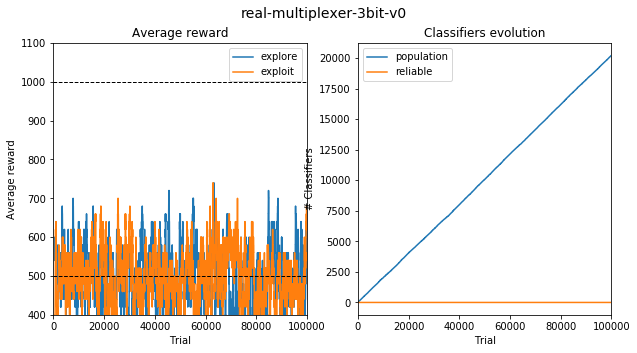

In [14]:
%%time

pop, metrics = evaluate(rmpx3, trials=100_000)

In [15]:
print_k_best(pop)

[0.00;1.00][0.00;1.00][0.04;0.04][0.00;1.00]	1	[0.00;1.00][0.00;1.00][0.00;1.00][0.00;1.00] x 1 fitness: 351.62
[0.83;0.83][0.00;1.00][0.00;1.00][0.00;1.00]	1	[0.00;1.00][0.00;1.00][0.00;1.00][0.00;1.00] x 1 fitness: 338.39
[0.00;1.00][0.00;1.00][0.67;0.67][0.00;1.00]	0	[0.00;1.00][0.00;1.00][0.00;1.00][0.00;1.00] x 1 fitness: 335.96
[0.08;0.08][0.00;1.00][0.00;1.00][0.00;1.00]	0	[0.00;1.00][0.00;1.00][0.00;1.00][0.00;1.00] x 1 fitness: 332.73
[0.07;0.07][0.00;1.00][0.00;1.00][0.00;1.00]	0	[0.00;1.00][0.00;1.00][0.00;1.00][0.00;1.00] x 1 fitness: 332.32
[0.00;1.00][0.00;1.00][0.56;0.56][0.00;1.00]	0	[0.00;1.00][0.00;1.00][0.00;1.00][0.00;1.00] x 1 fitness: 328.77
[0.21;0.21][0.00;1.00][0.00;1.00][0.00;1.00]	1	[0.00;1.00][0.00;1.00][0.00;1.00][0.00;1.00] x 1 fitness: 328.50
[0.00;1.00][0.00;1.00][0.78;0.78][0.00;1.00]	0	[0.00;1.00][0.00;1.00][0.00;1.00][0.00;1.00] x 1 fitness: 328.40
[0.00;1.00][0.00;1.00][0.34;0.34][0.00;1.00]	1	[0.00;1.00][0.00;1.00][0.00;1.00][0.00;1.00] x 1 fitness:

In [16]:
from lcs.representations import Interval

generic_ones = []

for p in pop:
    for c in p.condition:
        if c.p != c.q and c != Interval(0., 1.):
            generic_ones.append(p)
            break

print(len(generic_ones))

46


In [17]:
# Top 10 with some interval spread
sorted(generic_ones, key=lambda cl: -cl.fitness)[:10]

[[0.28;1.00][0.76;0.76][0.00;1.00][0.00;1.00]	0	[0.00;1.00][0.00;1.00][0.00;1.00][0.00;1.00] x 1 fitness: 217.18,
 [0.28;1.00][0.48;0.48][0.00;1.00][0.00;1.00]	0	[0.00;1.00][0.00;1.00][0.00;1.00][0.00;1.00] x 1 fitness: 206.32,
 [0.00;1.00][0.17;0.17][0.55;1.00][0.00;1.00]	0	[0.00;1.00][0.00;1.00][0.00;1.00][0.00;1.00] x 1 fitness: 184.56,
 [0.00;1.00][0.00;1.00][0.00;1.00][0.00;0.03]	1	[0.00;1.00][0.00;1.00][0.00;1.00][0.97;1.00] x 1 fitness: 181.35,
 [0.97;0.97][0.00;1.00][0.55;1.00][0.00;1.00]	0	[0.00;1.00][0.00;1.00][0.00;1.00][0.00;1.00] x 1 fitness: 175.33,
 [0.29;1.00][0.85;0.85][0.00;1.00][0.00;1.00]	1	[0.00;1.00][0.00;1.00][0.00;1.00][0.00;1.00] x 1 fitness: 172.66,
 [0.00;1.00][0.98;1.00][0.35;0.35][0.00;1.00]	0	[0.00;1.00][0.00;1.00][0.00;1.00][0.00;1.00] x 2 fitness: 167.55,
 [0.00;1.00][0.44;0.44][0.55;1.00][0.00;1.00]	0	[0.00;1.00][0.00;1.00][0.00;1.00][0.00;1.00] x 1 fitness: 166.57,
 [0.42;0.42][0.98;1.00][0.00;1.00][0.00;1.00]	0	[0.00;1.00][0.00;1.00][0.00;1.00][0.00;1